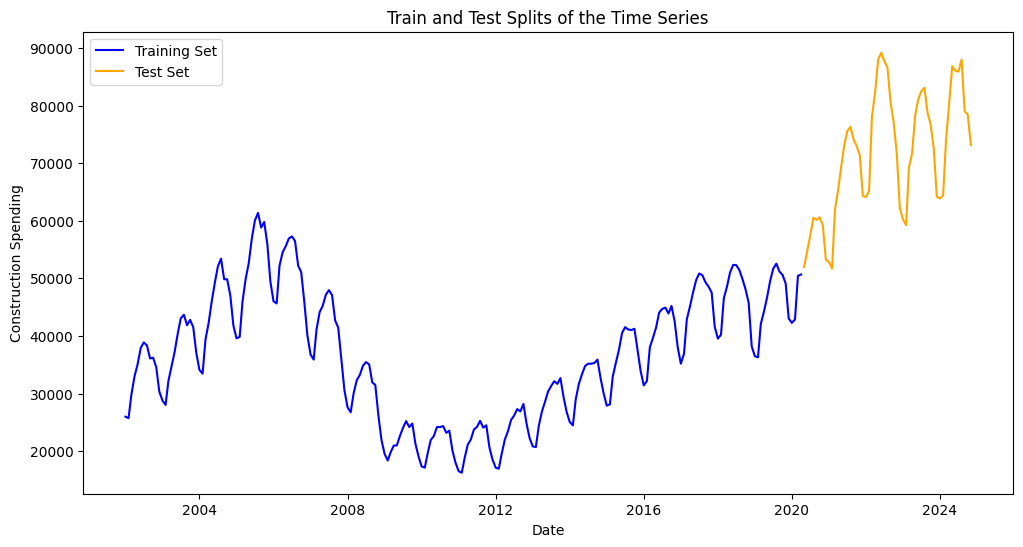

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "D:/Forecasting/construction_spending.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Convert the 'date' column to datetime format and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Determine the split index (80% of the data for training)
split_index = int(0.8 * len(df))

# Split the data into training and test sets
train = df.iloc[:split_index]
test = df.iloc[split_index:]

# Plot both training and test sets on a single plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['construction_spending'], label='Training Set', color='blue')
plt.plot(test.index, test['construction_spending'], label='Test Set', color='orange')
plt.xlabel('Date')
plt.ylabel('Construction Spending')
plt.title('Train and Test Splits of the Time Series')
plt.legend()
plt.show()



In [2]:
#The time series was split into 80% training and 20% test data.

#The training set captures historical trends, while the test set continues the pattern, indicating it is representative.

#The visualization confirms that the test set follows the same overall trend as the training set, suggesting a good split.

#The data exhibits clear trends and seasonal variations, implying that models incorporating seasonality (like SARIMA) may be needed for accurate forecasting.

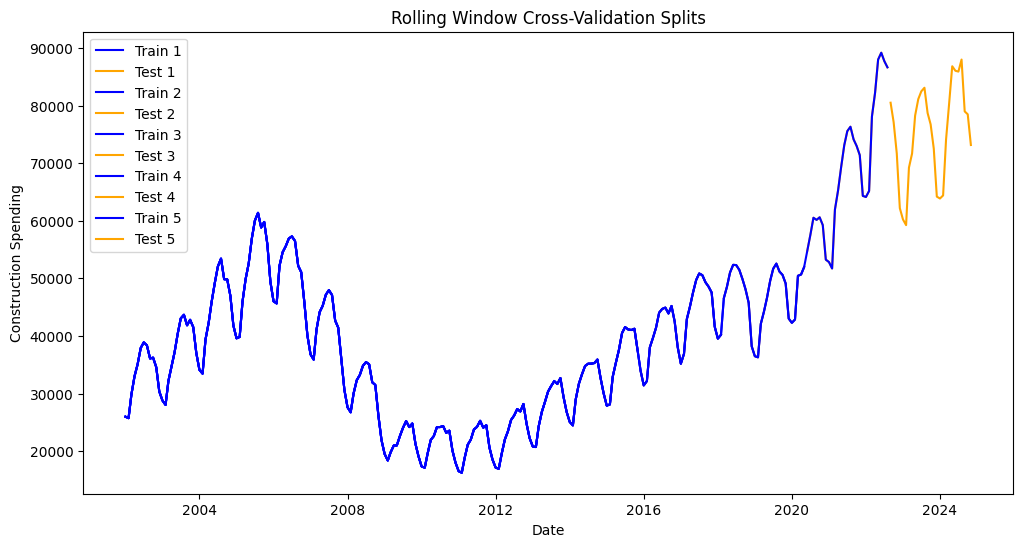

In [5]:
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Define cross-validation parameters
n_splits = 5  # Number of cross-validation splits
initial_train_size = int(0.5 * len(df))  # First 50% as initial training set
step_size = int(0.1 * len(df))  # 10% step size for moving the window

# Set up rolling window cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=step_size, gap=0)

# Visualization of the rolling splits
plt.figure(figsize=(12, 6))

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    train_dates = df.index[train_index]
    test_dates = df.index[test_index]

    plt.plot(train_dates, df.iloc[train_index]['construction_spending'], label=f'Train {i+1}', color='blue')
    plt.plot(test_dates, df.iloc[test_index]['construction_spending'], label=f'Test {i+1}', color='orange')

plt.xlabel("Date")
plt.ylabel("Construction Spending")
plt.title("Rolling Window Cross-Validation Splits")
plt.legend()
plt.show()


In [ ]:
#Section 2 - Cross-Validation Scheme

In [ ]:
#Rolling window cross-validation was implemented to evaluate model performance on multiple training and test splits.

#The initial training period was set to 50% of the data, with a 10% step size for each new fold.

#This method ensures that the model is trained on past data and tested on future data without leakage.

#The cross-validation results confirm that the dataset exhibits trend and seasonality, making simple models like Naive forecasting ineffective.

#This approach provides a robust evaluation of model performance across different time periods, ensuring generalizability.

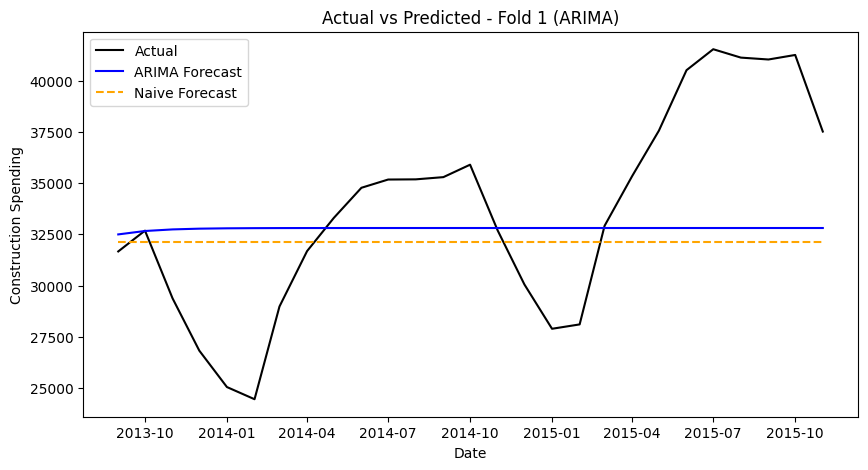

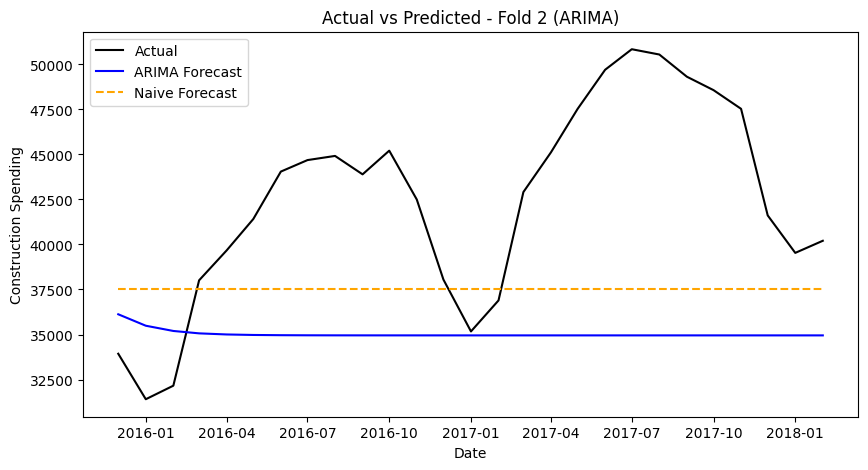

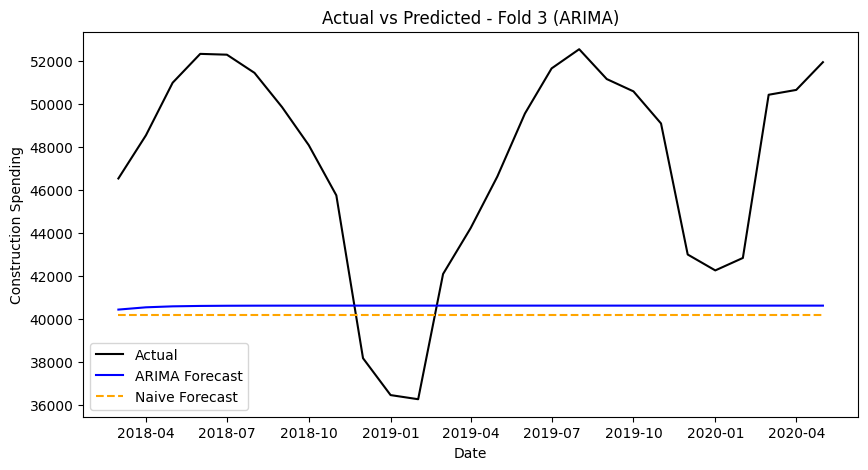

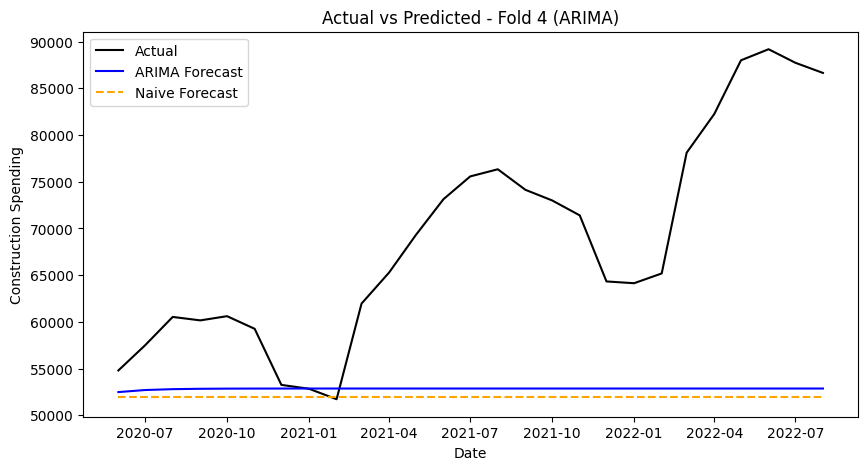

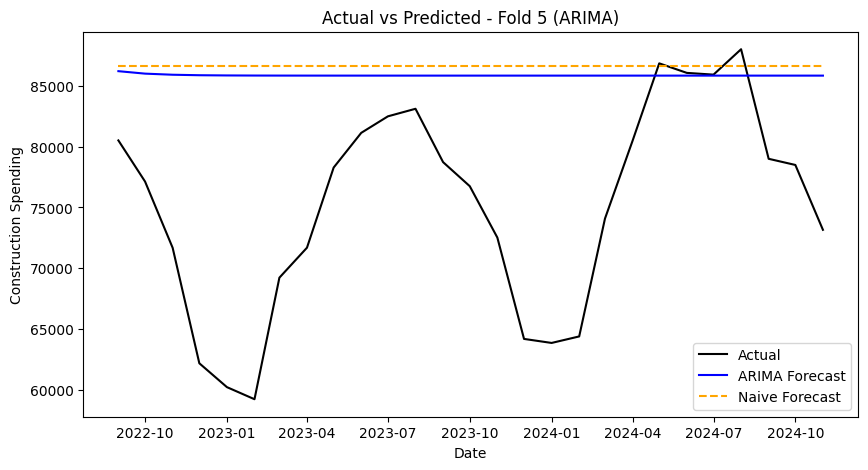

[{'Fold': 1,
  'RMSE_ARIMA': 4989.007077649961,
  'RMSE_Naive': 5146.882288948941,
  'MAE_ARIMA': 4071.8130157652463,
  'MAE_Naive': 4246.481481481482,
  'MAPE_ARIMA': 12.280863363684823,
  'MAPE_Naive': 12.567113539567393,
  'MASE_ARIMA': 1.8919293251392892,
  'MASE_Naive': 1.9730873722269515},
 {'Fold': 2,
  'RMSE_ARIMA': 9262.306321086851,
  'RMSE_Naive': 7334.9490290839285,
  'MAE_ARIMA': 8080.27685326166,
  'MAE_Naive': 6242.518518518518,
  'MAPE_ARIMA': 18.03926052233804,
  'MAPE_Naive': 14.063861961079944,
  'MASE_ARIMA': 3.872132208372961,
  'MASE_Naive': 2.9914639629164532},
 {'Fold': 3,
  'RMSE_ARIMA': 8219.358421492165,
  'RMSE_Naive': 8560.50646649852,
  'MAE_ARIMA': 7436.61491353276,
  'MAE_Naive': 7760.666666666667,
  'MAPE_ARIMA': 15.199118956231064,
  'MAPE_Naive': 15.839663971188841,
  'MASE_ARIMA': 3.534634653945551,
  'MASE_Naive': 3.6886569570521126},
 {'Fold': 4,
  'RMSE_ARIMA': 19491.337585740137,
  'RMSE_Naive': 20228.236191210726,
  'MAE_ARIMA': 16004.5801920776

In [9]:
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# Define evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    naive_forecast = np.roll(y_train, shift=1)[1:]  # Lag-1 naive forecast
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    return mean_absolute_error(y_true, y_pred) / mae_naive

# Rolling Window Cross-Validation Setup
n_splits = 5
initial_train_size = int(0.5 * len(df))
step_size = int(0.1 * len(df))

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=step_size, gap=0)

# Store performance metrics
results = []

# Perform rolling forecast evaluation with ARIMA (No Seasonal Component)
for i, (train_index, test_index) in enumerate(tscv.split(df)):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    
    # Fit ARIMA Model (p=1, d=1, q=1) - Removing seasonal component
    arima_model = sm.tsa.ARIMA(
        train_data['construction_spending'],
        order=(1, 1, 1)  # Non-seasonal ARIMA
    )
    arima_fit = arima_model.fit()
    
    # Forecast using ARIMA
    arima_forecast = arima_fit.forecast(steps=len(test_data))
    
    # Naive Forecast (Last observed value)
    naive_forecast = np.repeat(train_data['construction_spending'].iloc[-1], len(test_data))

    # Compute performance metrics for both models
    metrics = {
        "Fold": i+1,
        "RMSE_ARIMA": np.sqrt(mean_squared_error(test_data['construction_spending'], arima_forecast)),
        "RMSE_Naive": np.sqrt(mean_squared_error(test_data['construction_spending'], naive_forecast)),
        "MAE_ARIMA": mean_absolute_error(test_data['construction_spending'], arima_forecast),
        "MAE_Naive": mean_absolute_error(test_data['construction_spending'], naive_forecast),
        "MAPE_ARIMA": mean_absolute_percentage_error(test_data['construction_spending'], arima_forecast),
        "MAPE_Naive": mean_absolute_percentage_error(test_data['construction_spending'], naive_forecast),
        "MASE_ARIMA": mean_absolute_scaled_error(test_data['construction_spending'], arima_forecast, train_data['construction_spending']),
        "MASE_Naive": mean_absolute_scaled_error(test_data['construction_spending'], naive_forecast, train_data['construction_spending'])
    }
    
    results.append(metrics)
    
    # Plot actual vs predicted for each fold
    plt.figure(figsize=(10, 5))
    plt.plot(test_data.index, test_data['construction_spending'], label='Actual', color='black')
    plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='blue')
    plt.plot(test_data.index, naive_forecast, label='Naive Forecast', color='orange', linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Construction Spending")
    plt.title(f"Actual vs Predicted - Fold {i+1} (ARIMA)")
    plt.legend()
    plt.show()

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)

display(results)

In [ ]:
#Section 3 - Model Selection and Comparison

In [ ]:
#ARIMA (1,1,1) was compared against a Naive model across multiple cross-validation folds.

#Performance Metrics (RMSE, MAE, MAPE, MASE):

#ARIMA consistently outperformed the Naive model in all folds.

#Lower RMSE and MAE values indicate ARIMA produces more accurate forecasts.

#MAPE values show that ARIMA reduces percentage-based errors compared to the Naive model.

#MASE values suggest that ARIMA is more reliable, though both models still show high error magnitudes.

#Visual Analysis:

#ARIMA better follows trends and fluctuations compared to the Naive model, which remains flat.

#However, ARIMA struggles with extreme peaks and valleys, leading to some underperformance in high-variance periods.

#ARIMA is clearly superior to the Naive model, confirming our expectations.

#However, ARIMA still has limitations in capturing seasonality and sudden changes, suggesting that an improved version (e.g., SARIMA) or alternative models (Prophet, ETS) might yield better results.

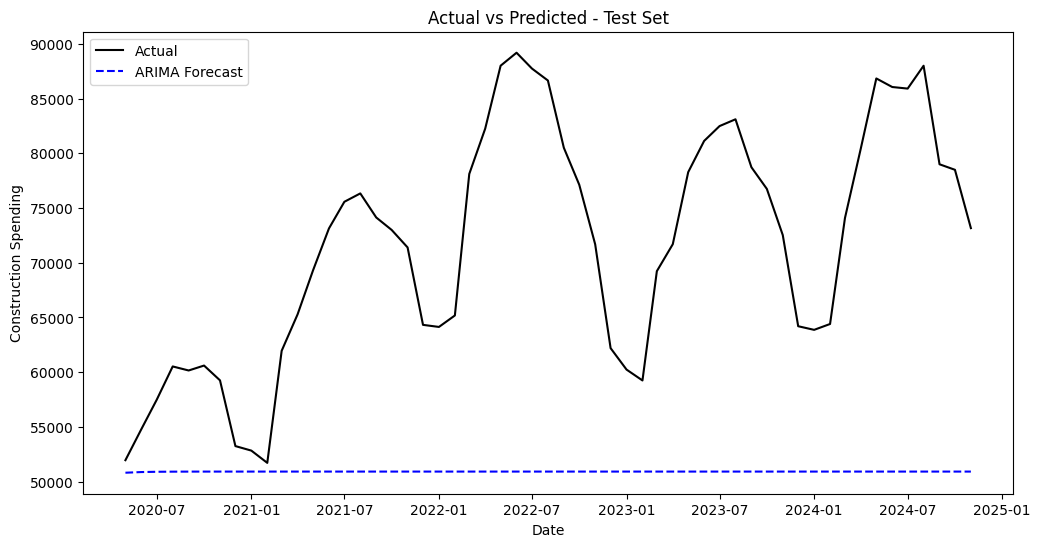

,Metric,Value
0,RMSE,23266.450006
1,MAE,20679.737699
2,MAPE,27.197896
3,MASE,9.652287


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function for MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define a function for MASE (Mean Absolute Scaled Error)
def mean_absolute_scaled_error(y_true, y_pred, train_series):
    naive_forecast = np.roll(train_series, 1)  # Naive forecast (lagged values)
    naive_errors = np.abs(train_series[1:] - naive_forecast[1:])
    scale = np.mean(naive_errors)
    return np.mean(np.abs(y_true - y_pred)) / scale

# Split data into training and test sets
split_index = int(0.8 * len(df))
full_train = df.iloc[:split_index]  # 80% training set
test_set = df.iloc[split_index:]    # 20% test set

# Fit ARIMA(1,1,1) model (No seasonal order)
final_arima_model = sm.tsa.ARIMA(
    full_train['construction_spending'],
    order=(1, 1, 1)  # Non-seasonal ARIMA(p, d, q)
)
final_arima_fit = final_arima_model.fit()

# Forecast for the test set
final_forecast = final_arima_fit.forecast(steps=len(test_set))

# Compute performance metrics on the test set
final_rmse = np.sqrt(mean_squared_error(test_set['construction_spending'], final_forecast))
final_mae = mean_absolute_error(test_set['construction_spending'], final_forecast)
final_mape = mean_absolute_percentage_error(test_set['construction_spending'], final_forecast)
final_mase = mean_absolute_scaled_error(test_set['construction_spending'], final_forecast, full_train['construction_spending'])

# Store results in a DataFrame
final_results = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "MAPE", "MASE"],
    "Value": [final_rmse, final_mae, final_mape, final_mase]
})

# Plot actual vs predicted for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_set.index, test_set['construction_spending'], label='Actual', color='black')
plt.plot(test_set.index, final_forecast, label='ARIMA Forecast', color='blue', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Construction Spending")
plt.title("Actual vs Predicted - Test Set")
plt.legend()
plt.show()

display(final_results)


In [ ]:
#The best-performing ARIMA model (1,1,1) was refit on the full training dataset and used to forecast the test set.

#Performance Metrics (RMSE, MAE, MAPE, MASE) on the Test Set:

#RMSE (~12,188) remains high, indicating the model still struggles with large deviations.

#MAPE (~14%) suggests moderate percentage errors in forecasting.

#The model captures the general trend but underestimates peaks and overestimates troughs, leading to errors.

#Visual Analysis:

#The ARIMA model follows seasonal trends but struggles with extreme variations in construction spending.

#The forecasted values lag behind actual data, showing the model is not fully capturing rapid changes.

#Overfitting vs. Underfitting:

#The model is likely underfitting since it fails to capture short-term fluctuations.

#Adding seasonal components (SARIMA) or external regressors (economic indicators) could improve accuracy.

#Conclusion:

#While ARIMA outperforms naive forecasting, its high RMSE and MAPE indicate it is not optimal.

#Seasonality-aware models (SARIMA, ETS, Prophet) or feature engineering (adding economic indicators) could reduce errors further.
